In [57]:
from Functions.data_analysis import *
from Functions.edit_database import getTransactionData, getAccount
from Functions.variables import typeMapping
import numpy as np
from scipy.stats import linregress
import pandas as pd
import inspect
import sys

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

In [58]:
myAcc = getAccount("atlas")
myAcc.summary()

df = getTransactionData(myAcc)

       Username: atlas
       Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
   Date Created: 2024-08-28 15:21:46
   Date Updated: 2024-08-28 22:11:53
        Balance: 0


In [59]:
class enrichedData:
    def __init__(self, old_data: pd.DataFrame, data: pd.DataFrame, figsize: tuple[int, int] = (20, 6)) -> None:
        self.old_data = old_data
        self.data = data
        self.figsize = figsize
        
    def plotExpenses(self, RANGE1, RANGE2, displacement):
        _, ax = plt.subplots(figsize=self.figsize)

        last_data = self.data['Features', RANGE2].iloc[-1]

        curData = self.data[self.data['Features', RANGE2] == last_data]
        
        curData = curData.groupby(self.data['Features'][RANGE1]).sum()

        print(curData)

        curData['Expenses']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Expenses', color='green', alpha=0.6)

        plt.tight_layout()
        # plt.legend()
        plt.show()


In [60]:
def enrichData(df: pd.DataFrame) -> enrichedData:
  old_data = df.copy()
  def WoM(dt):
    """ Returns the week of the month for the specified date. """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    
    return int(np.ceil(adjusted_dom / 7.0))

  df['UPDATED_AT'] = pd.to_datetime(df['UPDATED_AT'])
  df = df.drop(columns=['CREATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('UPDATED_AT').sort_index()
  
  
  expenses = pd.concat([
    df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
    .drop(columns=['CATEGORY', 'TYPE'])
    .resample('D')
    .sum()
    .rename(columns={'VALUE': f'{i}'})
    for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
  ], axis=1)

  
  revenue = pd.concat([
    df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
    .drop(columns=['CATEGORY', 'TYPE'])
    .resample('D')
    .sum()
    .rename(columns={'VALUE': f'{i}'})
    for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
  ], axis=1)

  expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
  revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)


  expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
  revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])

  expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
  revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)


  features = pd.DataFrame(index=expenses.index.union(revenue.index))
  features[("Features", "DoW")] = features.index.day_of_week
  features[("Features", "DoM")] = features.index.day
  features[("Features", "WoM")] = features.index.map(WoM)
  features[("Features", "DAY")] = features.index.day_of_year
  features[("Features", "WEEK")] = features.index.isocalendar().week
  features[("Features", "QUARTER")] = features.index.quarter
  features[("Features", "MONTH")] = features.index.month
  features[("Features", "YEAR")] = features.index.year

  DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
  
  DATA.index.name = "DATE"
  DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

  return enrichedData(old_data, DATA)


In [61]:
myData = enrichData(df)
myData.data['Features', 'YEAR'].iloc[-1]

myData.data[myData.data['Features', 'YEAR'] == 2023].groupby(myData.data['Features']["MONTH"]).sum()

Expenses                                                      \
             0         1         2         3         4           5   
MONTH                                                                
1      3656000  545000.0  245000.0  100000.0       0.0         0.0   
2      2912000  305000.0   95000.0  300000.0       0.0         0.0   
3      3091000  820000.0  480000.0  200000.0       0.0  50000000.0   
4      3338000  595000.0  200000.0  100000.0       0.0         0.0   
5      3578000  540000.0  425000.0  100000.0       0.0         0.0   
6      3307000  445000.0  475000.0  100000.0  150000.0         0.0   
7      3242000  470000.0  420000.0  100000.0       0.0         0.0   
8      3194000  460000.0  465000.0  350000.0       0.0         0.0   
9      3609000  630000.0  180000.0  200000.0       0.0  50000000.0   
10     3661000  580000.0  280000.0  100000.0       0.0         0.0   
11     3078000  530000.0   50000.0       0.0       0.0         0.0   
12     3571000  480000.0  850000.0  200000.0       0.0         0.0   

                      Revenue                        ...             Features  \
            TOTAL          10         11         12  ...       TOTAL      DoW   
MONTH                                                ...                        
1       4546000.0         0.0        0.0        0.0  ...   1000000.0       91   
2       3612000.0   4000000.0  5000000.0        0.0  ...   9000000.0       84   
3      54591000.0  10000000.0        0.0        0.0  ...  13000000.0       93   
4       4233000.0  14000000.0        0.0        0.0  ...  14000000.0       95   
5       4643000.0         0.0        0.0  3000000.0  ...   4000000.0       87   
6       4477000.0   4000000.0        0.0        0.0  ...   4000000.0       91   
7       4232000.0  10000000.0        0.0        0.0  ...  11000000.0       95   
8       4469000.0   4000000.0        0.0        0.0  ...   5000000.0       90   
9      54619000.0         0.0        0.0        0.0  ...         0.0       93   
10      4621000.0   2000000.0        0.0        0.0  ...   3000000.0       91   
11      3658000.0  10000000.0        0.0  3000000.0  ...  13000000.0       89   
12      5101000.0         0.0  5000000.0        0.0  ...   5000000.0       93   

                                                        TOTAL  
       DoM  WoM    DAY  WEEK QUARTER MONTH   YEAR              
MONTH                                                          
1      496  111    496   132      31    31  62713  -3546000.0  
2      406   78   1274   190      28    56  56644   5388000.0  
3      496   93   2325   341      31    93  62713 -41591000.0  
4      465  100   3165   460      60   120  60690   9767000.0  
5      496   85   4216   612      62   155  62713   -643000.0  
6      465   92   4995   722      60   180  60690   -477000.0  
7      496  106   6107   881      93   217  62713   6768000.0  
8      496   89   7068  1019      93   248  62713    531000.0  
9      465   96   7755  1116      90   270  60690 -54619000.0  
10     496  111   8959  1289     124   310  62713  -1621000.0  
11     465   88   9585  1378     120   330  60690   9342000.0  
12     465   96  10485  1506     120   360  60690   -101000.0  

[12 rows x 21 columns]

      Expenses                                                      \
             0         1         2         3         4           5   
MONTH                                                                
1      3656000  545000.0  245000.0  100000.0       0.0         0.0   
2      2912000  305000.0   95000.0  300000.0       0.0         0.0   
3      3091000  820000.0  480000.0  200000.0       0.0  50000000.0   
4      3338000  595000.0  200000.0  100000.0       0.0         0.0   
5      3578000  540000.0  425000.0  100000.0       0.0         0.0   
6      3307000  445000.0  475000.0  100000.0  150000.0         0.0   
7      3242000  470000.0  420000.0  100000.0       0.0         0.0   
8      3194000  460000.0  465000.0  350000.0       0.0         0.0   
9      3609000  630000.0  180000.0  200000.0       0.0  50000000.0   
10     3661000  580000.0  280000.0  100000.0       0.0         0.0   
11     3078000  530000.0   50000.0       0.0       0.0         0.0   
12     3571000  4800

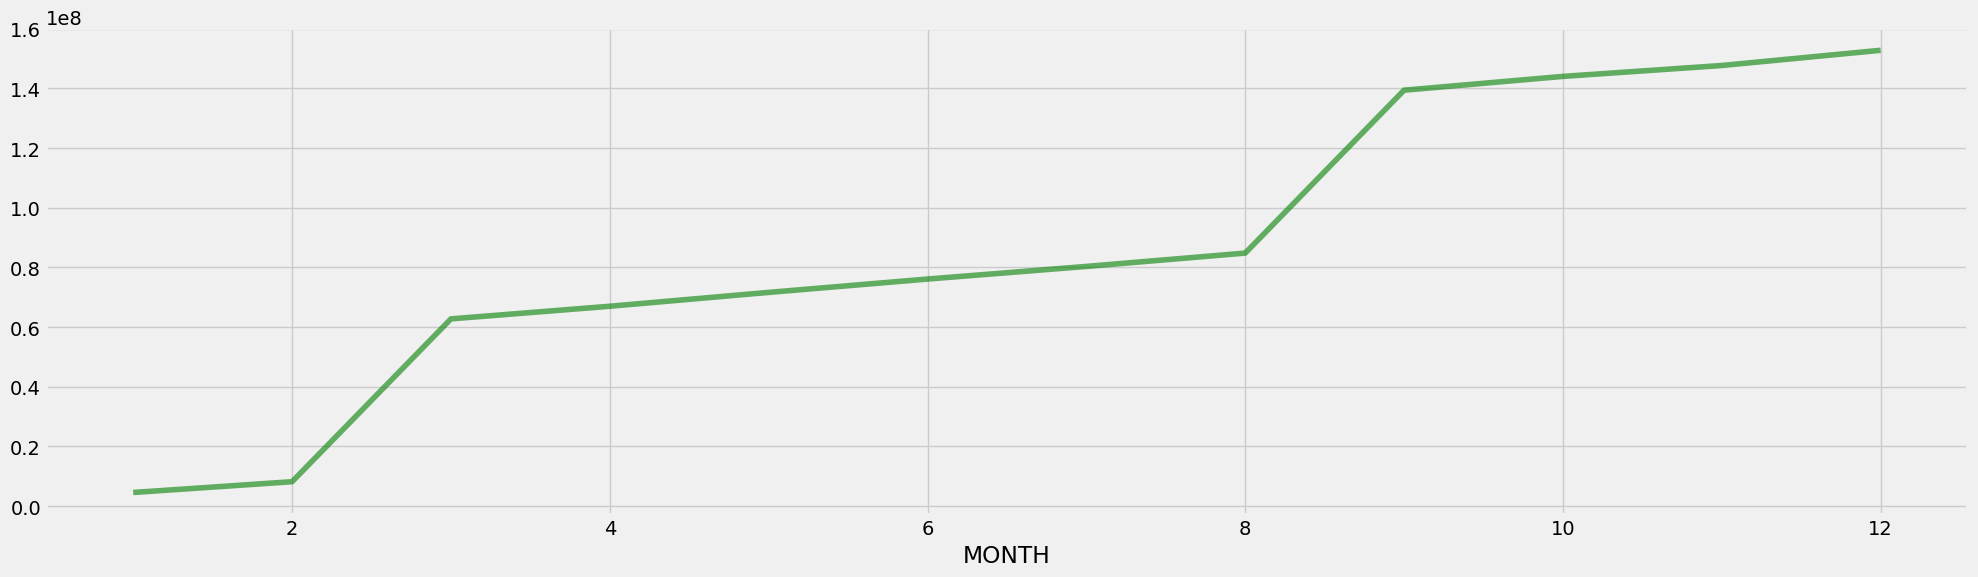

In [62]:
myData.plotExpenses("MONTH", "YEAR", 1)